In [310]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

This tool will track lines in the red (638 nm) and blue (488 nm) channels, and determine the binding lifetimes and orders of assembly and disassembly of the events. The two channels of colocalization can be changed by selecting all, and replacing all the instances of a color with the new color. That is, to compare green and red replace all instances of "blue" with "green". Note each channel has to first be tracked individually before performing the colocalization analysis.

At the end of this script  the event lifetimes, binding positions, colocalization categories, and duration of colocalizations will output as .txt files.

BSD 2-Clause License

Copyright (c) 2023, Matt Schaich
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [284]:
import matplotlib.pyplot as plt
import lumicks.pylake as lk
import itertools
import ipywidgets
import numpy as np
import glob
import os
import shutil
# We use skimage to downsample the data
from skimage.measure import block_reduce
from statistics import mean
from statistics import median
from scipy.stats import sem
from matplotlib_venn import venn2 #this line is used for making venn diagrams of interactions. 
#to generate venn diagrams matplotlib_venn must be installed via pip or conda.
%matplotlib inline
# Use notebook if you're in Jupyter Notebook
%matplotlib notebook
from kymowidget import KymoWidgetGreedy #imports the widget for kymograph analysis

In [285]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")

20210907-192448 Kymograph 20 10 fps DNA7 10 pN.h5


In [286]:
plt.close('all')#This closes any plots left open to save memory and loads up the .h5 file in folder
file = lk.File(str(filename[0]))
list(file.kymos)

['20 10 fps DNA7 10 pN']

20210907-192448 Kymograph 20 10 fps DNA7 10 pN.h5


<IPython.core.display.Javascript object>


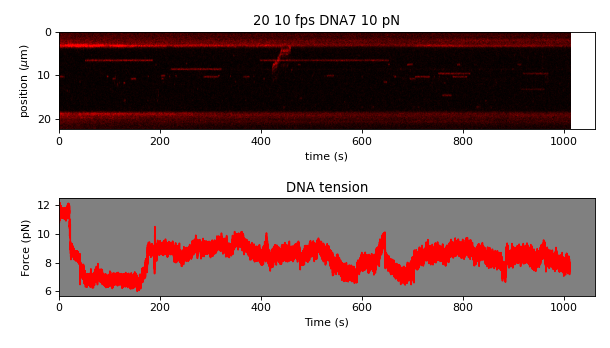

In [287]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")

plt.close('all')#This closes any plots left open to save memory and loads up the .h5 file in folder
file = lk.File(str(filename[0]))
_, kymo = file.kymos.popitem()

forcex = file["Force HF"]["Force 1x"] #this cell downsamples the force to save memory and make it easier to visualize

# time traces (seconds)
time = forcex.timestamps/1e9
time = time - time[0]
sample_rate = forcex.sample_rate

downsampled_rate = 50 # Hz, this rate can be changed as needed

# downsample the force, nanostage position and time
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]

median_force = (median(forcex_downsamp.data))

_, kymo = file.kymos.popitem() #after defining the downsample rate earlier, this actually does the downsampling


# Plot the kymograph
plt.figure(figsize=(7, 4)) #this plots the kymograph side-by-side with the force

ax1 = plt.subplot(2, 1, 1)
plt.title('Red channel of kymograph of interest')
# We use aspect="auto" because otherwise the kymo would be very long and thin
kymo.plot_red(vmax=2, aspect="auto")


# Plot the force
ax2 = plt.subplot(2, 1, 2, sharex = ax1)
forcex_downsamp.plot(color='red')
plt.ylabel('Force (pN)')
plt.tight_layout()
plt.title('DNA tension')
ax2.set_facecolor('gray')
plt.show()

pixel_size = kymo.pixelsize_um
pixel_size_int = pixel_size[0]
data = kymo.red_image
dt = kymo.line_time_seconds
pixel_size = kymo.pixelsize_um
pixel_size_int = pixel_size[0]

In [288]:
kw = KymoWidgetGreedy(data, axis_aspect_ratio=2, min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)
#this first plot is to look at the kymograph on the pixel scale in order to decide if an upper and lower bound need to be applied

In [289]:
#Trim the data to avoid the beads by defining upper and lower bounds
lower_bound= 34
adjusted_lower_bound = pixel_size_int * lower_bound
upper_bound= 184
adjusted_upper_bound = pixel_size_int * upper_bound
data = data[lower_bound:upper_bound, :] 
kymo.red_data = kymo.red_image[lower_bound:upper_bound, :]
kymo.green_data = kymo.green_image[lower_bound:upper_bound, :]
steps_between_bounds = int((adjusted_upper_bound - adjusted_lower_bound) * 10) #defines number of 100 nm steps between bounds
kymo.blue_data = kymo.blue_image[lower_bound:upper_bound, :]
plt.close('all')

#Define a downsample factor here to downsample data if needed. Note that all colors must be downsampled the same ratio for the
#colocalization analysis to work properly

downsample_factor = 2

In [290]:
#perform red event line tracking in this cell
red_lines = lk.KymoWidgetGreedy(kymo.downsampled_by(downsample_factor), "red", aspect="auto", min_length=4, line_width=0.5, pixel_threshold=1, window=7, sigma=0.25, vmax=2)

In [291]:
#recommended to save the lines by the color (i.e., red lines as redkymotracks.txt)
red_lines.save_lines("redkymotracks.txt", sampling_width=3)

In [292]:
#perform blue event line tracking in this cell
blue_lines = lk.KymoWidgetGreedy(kymo.downsampled_by(downsample_factor), "blue", aspect="auto", min_length=4, line_width=0.5, pixel_threshold=1, window=12, sigma=0.25, vmax=2)

In [293]:
#recommended to save the lines by the color (i.e., blue lines as bluekymotracks.txt)
blue_lines.save_lines("bluekymotracks.txt", sampling_width=3)

In [294]:
#this cell outputs the number of lines in the kymo and also defines number of bins based on events^1/2
#if the kymotracking didn't work, the number will be 0
numberofredlines = len(red_lines.lines)
print (numberofredlines)
numberofredbins = int(round(np.sqrt (numberofredlines)) )
print (numberofredbins)
#below section for blue lines
numberofbluelines = len(blue_lines.lines)
print (numberofbluelines)
numberofbluebins = int(round(np.sqrt (numberofbluelines)) )
print (numberofbluebins)


57
8
35
6


1


<IPython.core.display.Javascript object>


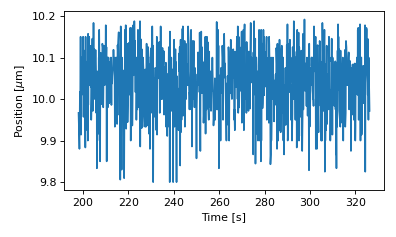

<IPython.core.display.Javascript object>


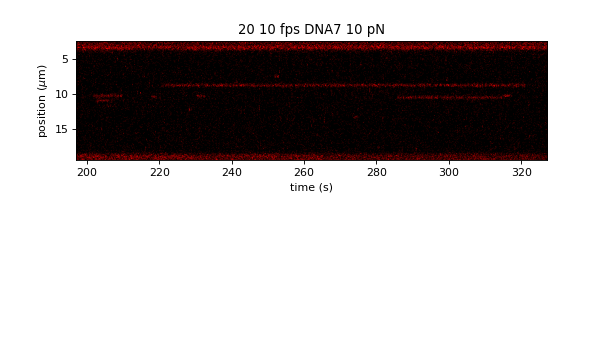

10


<IPython.core.display.Javascript object>


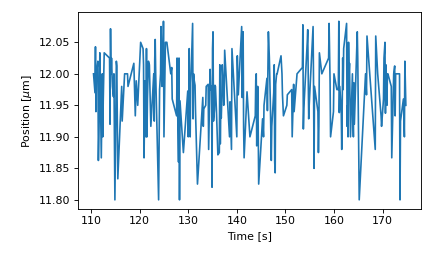

<IPython.core.display.Javascript object>


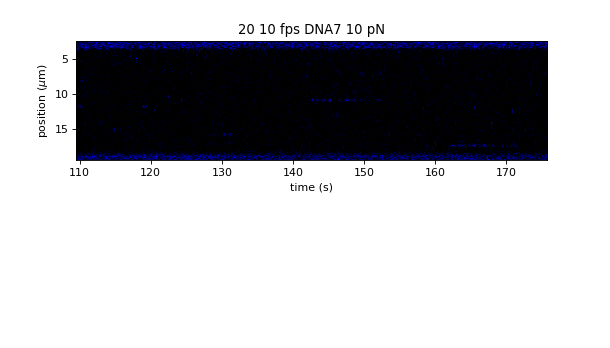

(19.400000000000002, 2.4000000000000004)

In [295]:
#RED LINES SECTION--------------------------------------------------------------
redlengths = [len(line) for line in red_lines.lines]
# Get the index of the longest kymo line
redlongest_index = np.argmax(redlengths)

# Select the longest red line
redlongest_line = red_lines.lines[redlongest_index]

print(redlongest_index)
#this section plots the positions of the longest line and also shows the raw image of that line 
#also leaves 1 second empty on each side so the start and end can be seen.
plt.figure(figsize=(5, 3))
plt.plot(np.array(redlongest_line.time_idx) * dt, np.array(redlongest_line.coordinate_idx ) * pixel_size + adjusted_lower_bound) 
plt.xlabel('Time [s]')
plt.ylabel('Position [$\mu$m]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
ax1 = plt.subplot(2, 1, 1)
kymo.plot_red(vmax=3, aspect="auto")
ax1.set_xlim([(np.array(redlongest_line.time_idx[0])) * dt -1, (np.array(redlongest_line.time_idx[-1]) * dt +1 )])
ax1.set_ylim(adjusted_upper_bound+1, adjusted_lower_bound-1) 

#BLUE LINES SECTION--------------------------------------------------------------
bluelengths = [len(line) for line in blue_lines.lines]
# Get the index of the longest kymo line
bluelongest_index = np.argmax(bluelengths)

# Select the longest blue line
bluelongest_line = blue_lines.lines[bluelongest_index]

print(bluelongest_index)
#this section plots the positions of the longest line and also shows the raw image of that line 
#also leaves 1 second empty on each side so the start and end can be seen.
plt.figure(figsize=(5, 3))
plt.plot(np.array(bluelongest_line.time_idx) * dt, np.array(bluelongest_line.coordinate_idx ) * pixel_size + adjusted_lower_bound) 
plt.xlabel('Time [s]')
plt.ylabel('Position [$\mu$m]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
ax1 = plt.subplot(2, 1, 1)
kymo.plot_blue(vmax=3, aspect="auto")
ax1.set_xlim([(np.array(bluelongest_line.time_idx[0])) * dt -1, (np.array(bluelongest_line.time_idx[-1]) * dt +1 )])
ax1.set_ylim(adjusted_upper_bound+1, adjusted_lower_bound-1) 

<IPython.core.display.Javascript object>


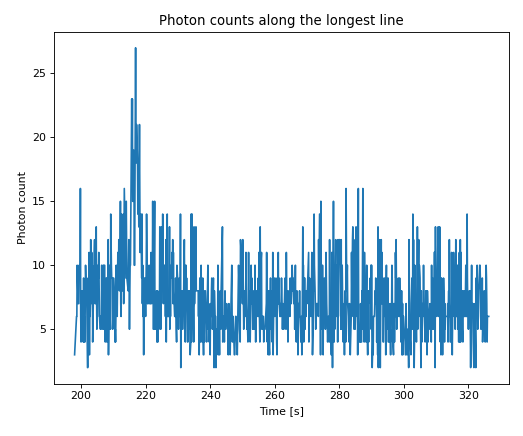

<IPython.core.display.Javascript object>


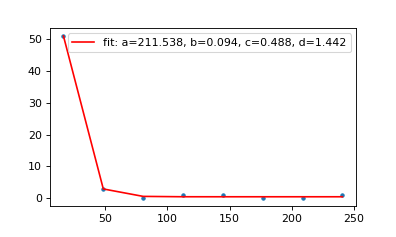

10.583309671452191


<IPython.core.display.Javascript object>


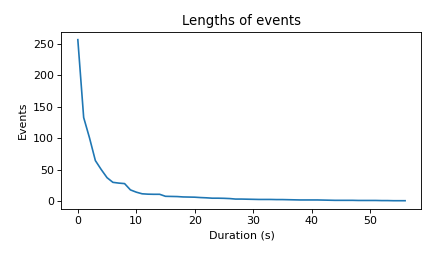

<IPython.core.display.Javascript object>


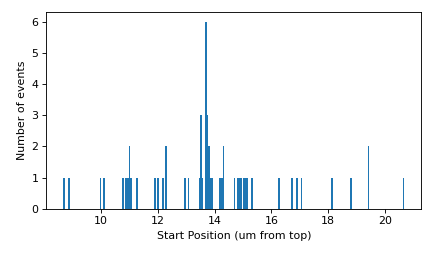

<IPython.core.display.Javascript object>


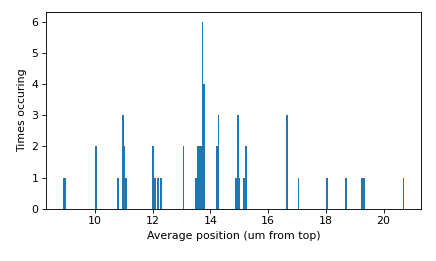

<IPython.core.display.Javascript object>


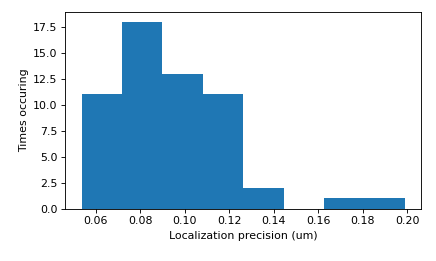

<IPython.core.display.Javascript object>


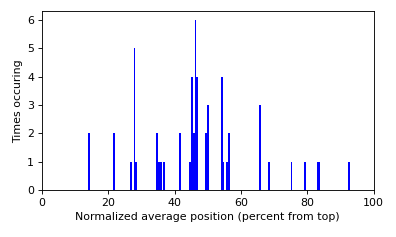

<IPython.core.display.Javascript object>


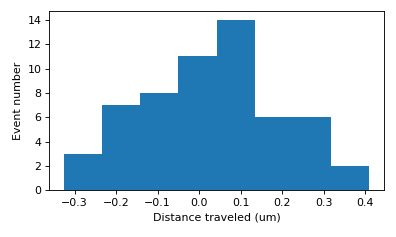

<IPython.core.display.Javascript object>


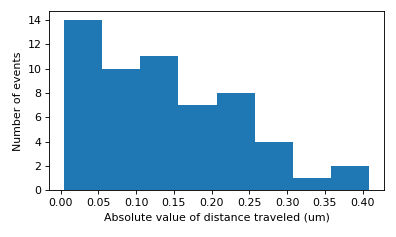

In [296]:
#THIS CELL FOR PROCESSING RED CHANNEL DATA
#to plot photon count along the longest line
plt.figure(figsize=(6, 5))
plt.plot( np.array(redlongest_line.time_idx) * dt, redlongest_line.sample_from_image(3)) #this samples 3 pixels away from line position
plt.ylabel('Photon count')
plt.xlabel('Time [s]')
plt.title('Photon counts along the longest line')
plt.tight_layout()
plt.show()

#fits the data to a single exponential decay
from scipy.optimize import curve_fit
def func(x, a, b, c,d):
    return a * np.exp(-b * (x-d)) + c 
redtimes = np.array([(line.time_idx[-1]-line.time_idx[0]) for line in red_lines.lines])*dt*downsample_factor
counts,bins=np.histogram(redtimes, bins=numberofredbins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(func, binscenters, counts, bounds=(0, [500, 1, 10, 5]))

plt.figure(figsize=(5,3))
plt.plot(binscenters,counts,'.')
plt.plot(binscenters, func(binscenters, *popt), 'r-',

         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
redlifetime = 1 / popt[1]
print (redlifetime)
plt.legend()
plt.show()
# for this dataset, this translates to a t1/2 of 1 s (1/b = 1 s)

#plots line length as a histogram. numberofbins was defined earlier as square root of n

plt.figure(figsize=(5, 3))
plt.plot(np.flipud(np.sort (redtimes)))
plt.ylabel('Events')
plt.xlabel('Duration (s)')
plt.title('Lengths of events')
plt.tight_layout()
plt.show()


#histogram of starting positions for each line
redtime = [(line.time_idx[0]) * dt for line in red_lines.lines]
##np.array(longest_line.coordinate_idx) * pixel_size / 1000
startpositions = np.array([line.coordinate_idx[0] for line in red_lines.lines]) * pixel_size + adjusted_lower_bound
plt.figure(figsize=(5, 3))
plt.hist(startpositions, 214) #Arbitrarily defined a bunch of bins on this, roughly corresponding to 100 nm. This can be altered.
plt.xlabel('Start Position (um from top)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()


#histogram of mean positions for each line
redmeanpositions = np.array([np.average(line.coordinate_idx) for line in red_lines.lines]) * pixel_size + adjusted_lower_bound
plt.figure(figsize=(5, 3))
plt.hist(redmeanpositions, 214)
plt.xlabel('Average position (um from top)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of localization precision in um
redstandarddeviation = np.array([np.std(line.coordinate_idx, ddof=1) for line in red_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(redstandarddeviation, numberofredbins)
plt.xlabel('Localization precision (um)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()
#this saves the MSD vlues as a .txt file in case we want to graph these in excel/prism. Still under development.
np.savetxt("redstd.txt", 
           redstandarddeviation,
           delimiter =", ",
            fmt = "%s")

#histogram of normalized line positions in terms of percentage along DNA bound. 
#To function properly, upper and lower bound must be defined as the edge of the beads.
rednorm_meanpositions = np.array([np.average(line.coordinate_idx-lower_bound) for line in red_lines.lines])  /(upper_bound-lower_bound) * 100
plt.figure(figsize=(5, 3))
plt.hist(rednorm_meanpositions, steps_between_bounds, color='blue')
plt.xlabel('Normalized average position (percent from top)')
plt.xlim(0, 100)
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of the difference between the start and endpoint of each line
reddistancetraveled = np.array([line.coordinate_idx[-1]-line.coordinate_idx[0] for line in red_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(reddistancetraveled, numberofredbins)
plt.ylabel('Event number')
plt.xlabel('Distance traveled (um)')
plt.tight_layout()
plt.show()


#histogram of the absolute value of the difference between the start and endpoint of each line
redabsdistancetraveled = np.array([abs(line.coordinate_idx[-1]-line.coordinate_idx[0]) for line in red_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(redabsdistancetraveled, numberofredbins)
plt.xlabel('Absolute value of distance traveled (um)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


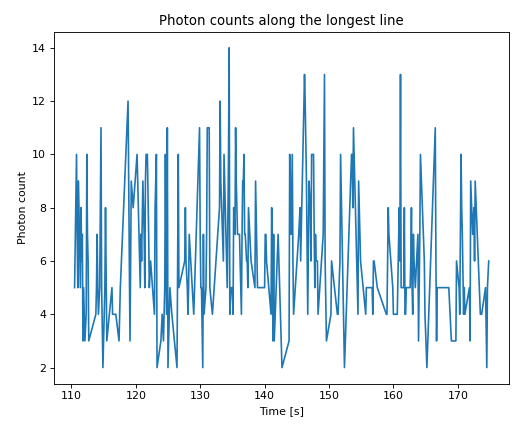

<IPython.core.display.Javascript object>


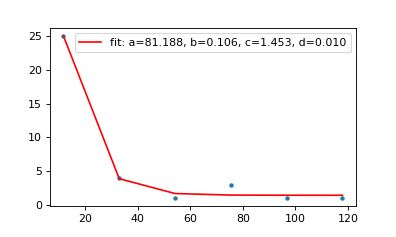

9.391442290267111


<IPython.core.display.Javascript object>


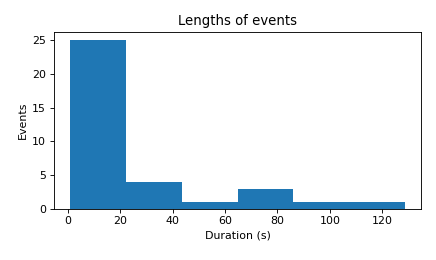

<IPython.core.display.Javascript object>


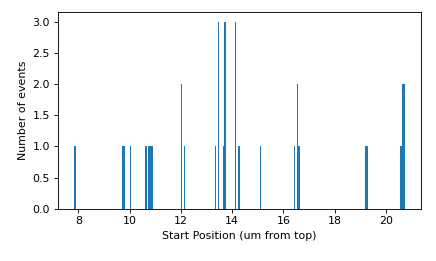

<IPython.core.display.Javascript object>


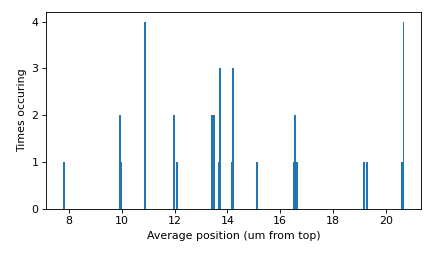

C:\Users\schaichm\AppData\Local\Temp/ipykernel_19672/2922393024.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 3))


<IPython.core.display.Javascript object>


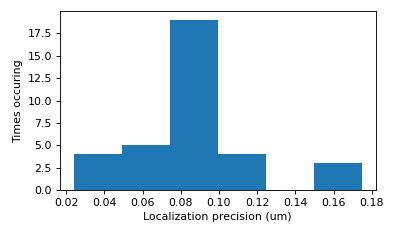

<IPython.core.display.Javascript object>


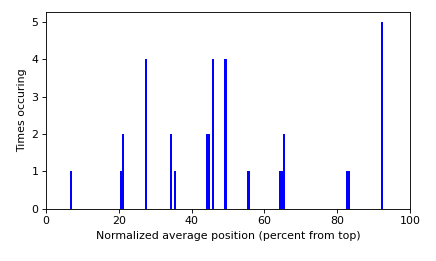

<IPython.core.display.Javascript object>


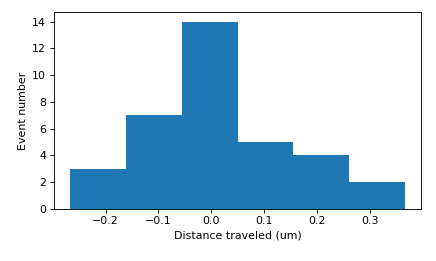

<IPython.core.display.Javascript object>


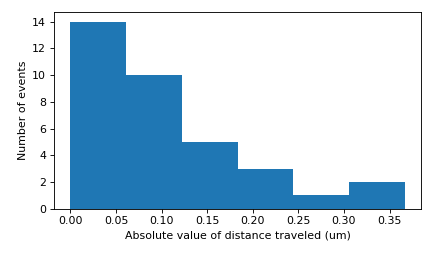

In [297]:
#THIS CELL FOR PROCESSING BLUE CHANNEL DATA
#to plot photon count along the longest line
plt.figure(figsize=(6, 5))
plt.plot( np.array(bluelongest_line.time_idx) * dt, bluelongest_line.sample_from_image(3)) #this samples 3 pixels away from line position
plt.ylabel('Photon count')
plt.xlabel('Time [s]')
plt.title('Photon counts along the longest line')
plt.tight_layout()
plt.show()

#fits the data to a single exponential decay
from scipy.optimize import curve_fit
def func(x, a, b, c,d):
    return a * np.exp(-b * (x-d)) + c 
bluetimes = np.array([(line.time_idx[-1]-line.time_idx[0]) for line in blue_lines.lines])*dt*downsample_factor 
counts,bins=np.histogram(bluetimes, bins=numberofbluebins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(func, binscenters, counts, bounds=(0, [5000, 1, 5, 0.01]))

plt.figure(figsize=(5,3))
plt.plot(binscenters,counts,'.')
plt.plot(binscenters, func(binscenters, *popt), 'r-',

         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
bluelifetime = 1 / popt[1]
print (bluelifetime)
plt.legend()
plt.show()


#plots line length as a histogram. numberofbins was defined earlier as square root of n
plt.figure(figsize=(5, 3))
plt.hist(bluetimes, numberofbluebins)
plt.ylabel('Events')
plt.xlabel('Duration (s)')
plt.title('Lengths of events')
plt.tight_layout()
plt.show()


#histogram of starting positions for each line
bluetime = [(line.time_idx[0]) * dt for line in blue_lines.lines]
##np.array(longest_line.coordinate_idx) * pixel_size / 1000
startpositions = np.array([line.coordinate_idx[0] for line in blue_lines.lines]) * pixel_size + adjusted_lower_bound
plt.figure(figsize=(5, 3))
plt.hist(startpositions, 214) #Arbitrarily defined a bunch of bins on this, roughly corresponding to 100 nm. This can be altered.
plt.xlabel('Start Position (um from top)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()


#histogram of mean positions for each line
bluemeanpositions = np.array([np.average(line.coordinate_idx) for line in blue_lines.lines]) * pixel_size + adjusted_lower_bound
plt.figure(figsize=(5, 3))
plt.hist(bluemeanpositions, 214)
plt.xlabel('Average position (um from top)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of localization precision in um
bluestandarddeviation = np.array([np.std(line.coordinate_idx, ddof=1) for line in blue_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(bluestandarddeviation, numberofbluebins)
plt.xlabel('Localization precision (um)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()
#this saves the MSD vlues as a .txt file in case we want to graph these in excel/prism. Still under development.
np.savetxt("bluestd.txt", 
           bluestandarddeviation,
           delimiter =", ",
            fmt = "%s")

#histogram of normalized line positions in terms of percentage along DNA bound. 
#To function properly, upper and lower bound must be defined as the edge of the beads.
bluenorm_meanpositions = np.array([np.average(line.coordinate_idx-lower_bound) for line in blue_lines.lines])  /(upper_bound-lower_bound) * 100
plt.figure(figsize=(5, 3))
plt.hist(bluenorm_meanpositions, steps_between_bounds, color='blue')
plt.xlabel('Normalized average position (percent from top)')
plt.xlim(0, 100)
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of the difference between the start and endpoint of each line
bluedistancetraveled = np.array([line.coordinate_idx[-1]-line.coordinate_idx[0] for line in blue_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(bluedistancetraveled, numberofbluebins)
plt.ylabel('Event number')
plt.xlabel('Distance traveled (um)')
plt.tight_layout()
plt.show()


#histogram of the absolute value of the difference between the start and endpoint of each line
blueabsdistancetraveled = np.array([abs(line.coordinate_idx[-1]-line.coordinate_idx[0]) for line in blue_lines.lines]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(blueabsdistancetraveled, numberofbluebins)
plt.xlabel('Absolute value of distance traveled (um)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()


In [298]:
#Colocalization analysis
colocalization_count = 0
interaction_tuple = []
interaction_window = 2 #distance in pixels for an interaction to occur
time_window = 8 #distance in frames for an interaction to occur
#the following loop iterates over the length of each line, comparing every coordinate to the coordinate of all lines of the other color
#if a point between both is closer than the interaction window and occurs within the time window, the interacting lines will
#be appended to the interaction tuple as coordinates
for l in range (0, numberofredlines):
    redlinelength = len((red_lines.lines[l].coordinate_idx))
    for i in range (0, redlinelength):
        for j in range (0, numberofbluelines):
            bluelinelength = len((blue_lines.lines[j].coordinate_idx))
            for k in range (0, bluelinelength):
                if abs(blue_lines.lines[j].coordinate_idx[k]-red_lines.lines[l].coordinate_idx[i]) <= interaction_window and abs(blue_lines.lines[j].time_idx[k] - red_lines.lines[l].time_idx[i]) <= time_window: 
                
                    colocalization_count = colocalization_count + 1
                    if len(interaction_tuple) > 0:
                        if j != interaction_tuple [len(interaction_tuple)-1][1]:
                            interaction_tuple.append((l, j))

                            break
                        break
                    else: interaction_tuple.append((l,j))
                break

In [299]:
#Colocalization analysis
colocalization_count = 0
blue_interaction_tuple = []

interaction_window = 2 #distance in pixels for an interaction to occur
time_window = 8 #distance in frames for an interaction to occur
#the following loop iterates over the length of each line, comparing every coordinate to the coordinate of all lines of the other color
#if a point between both is closer than the interaction window and occurs within the time window, the interacting lines will
#be appended to the interaction tuple as coordinates
for l in range (0, numberofbluelines):
    bluelinelength = len((blue_lines.lines[l].coordinate_idx))
    for i in range (0, bluelinelength):
        for j in range (0, numberofredlines):
            redlinelength = len((red_lines.lines[j].coordinate_idx))
            for k in range (0, redlinelength):
                if abs(red_lines.lines[j].coordinate_idx[k]-blue_lines.lines[l].coordinate_idx[i]) <= interaction_window and abs(red_lines.lines[j].time_idx[k] - blue_lines.lines[l].time_idx[i]) <= time_window: 
                
                    colocalization_count = colocalization_count + 1
                    #print (l, j)
                    if len(blue_interaction_tuple) > 0:
                        if j != blue_interaction_tuple [len(blue_interaction_tuple)-1][0]:
                            blue_interaction_tuple.append((j, l))

                            break
                        break
                    else: blue_interaction_tuple.append((j,l))
                break

            

blue_interaction_tuple.sort()        


In [300]:
unique_sub_cats = []
for ind in blue_interaction_tuple:
    if ind not in interaction_tuple:
        unique_sub_cats.append(ind)


for i in range (0, len(unique_sub_cats)):
    interaction_tuple.append(unique_sub_cats[i])

print (interaction_tuple, "are the interacting lines in the format (red, blue)")


[(1, 0), (1, 2), (2, 10), (9, 26), (11, 6), (14, 8), (19, 29), (20, 9), (24, 3), (29, 25), (37, 15), (40, 4), (41, 13), (45, 33), (47, 19), (48, 20), (50, 34), (51, 21), (51, 22), (52, 23), (12, 7), (21, 9), (25, 3), (38, 14)] are the interacting lines in the format (red, blue)


In [301]:
#interaction statistics
total_interactions=len(interaction_tuple)
print (len(interaction_tuple), 'total interactions')
blueinteractions = 1 #there has to be at least one interaction to start with, to compare for unique interactions
if len(interaction_tuple) >0: # this statement checks that there is indeed 1 or more interactions. If not it sets the count to 0
    for i in range (0, len(interaction_tuple)-1):
        if interaction_tuple[i][0] != interaction_tuple[i+1][0]:
            blueinteractions = blueinteractions + 1
else:
    blueinteractions = 0

redinteractions = 1 #same as above but for red lines
if len(interaction_tuple) >0:
    for k in range (0, len(interaction_tuple)-1):
        if interaction_tuple[k][1] != interaction_tuple[k+1][1]:
            redinteractions = redinteractions + 1
else:
    redinteractions = 0
    




24 total interactions


<IPython.core.display.Javascript object>


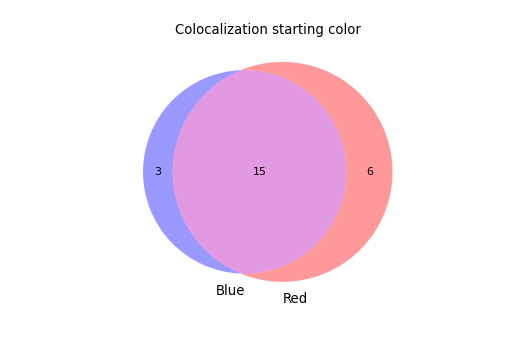

[6, 9, 8, 7, 10, 7, 7, 8, 8, 7, 7, 8, 10, 6, 8, 7, 7, 9, 11, 10, 5, 4, 5, 7]


In [302]:
#further colocalization patterns -- of the colocalizations, how many start with blue, how many start with red, how many together?
plt.close('all')
timing_window = 6 #allowed window for events to occur at the same time
interaction_starts = [] #if red comes on first, this is 0, if they start together: 1, if blue is first: 2
for i in range (0, len(interaction_tuple)):
    if ((red_lines.lines[interaction_tuple[i][0]].time_idx[0]-blue_lines.lines[interaction_tuple[i][1]].time_idx[0]) > timing_window):
        interaction_starts.append(2)
    if (abs(red_lines.lines[interaction_tuple[i][0]].time_idx[0]-blue_lines.lines[interaction_tuple[i][1]].time_idx[0]) <= timing_window):
        interaction_starts.append(1)
    if ((blue_lines.lines[interaction_tuple[i][1]].time_idx[0]-red_lines.lines[interaction_tuple[i][0]].time_idx[0]) > timing_window):
        interaction_starts.append(0)
#these outputs can be printed out for a double check if desired
#print (interaction_starts)
#print ('From',len(interaction_starts), 'interactions')

#further colocalization patterns -- of the colocalizations, how many end with blue, how many end with red, how many together?

timing_window = 6 #allowed window for events to occur at the same time
interaction_ends = [] #if red leaves first, this is 0, if they leave together: 1, if blue leaves first: 2
for i in range (0, len(interaction_tuple)):
    if ((red_lines.lines[interaction_tuple[i][0]].time_idx[-1]-blue_lines.lines[interaction_tuple[i][1]].time_idx[-1]) > timing_window):
        interaction_ends.append(2)
    if (abs(red_lines.lines[interaction_tuple[i][0]].time_idx[-1]-blue_lines.lines[interaction_tuple[i][1]].time_idx[-1]) <= timing_window):
        interaction_ends.append(1)
    if ((blue_lines.lines[interaction_tuple[i][1]].time_idx[-1]-red_lines.lines[interaction_tuple[i][0]].time_idx[-1]) > timing_window):
        interaction_ends.append(0)
#these outputs can be printed out for a double check if desired
#print (interaction_ends)
#print ('From',len(interaction_ends), 'interactions')


bluestart = interaction_starts.count(2)
doublestart = interaction_starts.count(1)
redstart = interaction_starts.count(0)


blueend = interaction_ends.count(0)
doubleend = interaction_ends.count(1)
redend = interaction_ends.count(2)
#print (redend)
# this section quantifies these phenomena to make venn diagrams based on what color starts and what color ends
# basically this is a rough way of displaying order of assembly and dissassembly
venn2(subsets = (bluestart, redstart, doublestart), set_labels = ('Blue', 'Red'), set_colors=('blue', 'red'));
plt.title("Colocalization starting color")
plt.show()
#this section generates a table categorizing each ternary event into 1 of 9 possible categories
# in other words, this is a more rigorous way of showing order of assembly and dissassembly
#this list starts as 3 as category 1 and 2 represent binary events

interaction_categories = []

for i in range (0, len(interaction_tuple)):
    if interaction_starts[i] == 0:
        if interaction_ends[i] == 0:
            interaction_categories.append(11)
        if interaction_ends[i] == 1: 
            interaction_categories.append(10)
        if interaction_ends[i] == 2: 
            interaction_categories.append(9)    
    if interaction_starts[i] == 1:
        if interaction_ends[i] == 0:
            interaction_categories.append(8)
        if interaction_ends[i] == 1: 
            interaction_categories.append(7)
        if interaction_ends[i] == 2: 
            interaction_categories.append(6) 
    if interaction_starts[i] == 2:
        if interaction_ends[i] == 0:
            interaction_categories.append(5)
        if interaction_ends[i] == 1: 
            interaction_categories.append(4)
        if interaction_ends[i] == 2: 
            interaction_categories.append(3)
            
print (interaction_categories)
#this prints out all of the categories as a list


<IPython.core.display.Javascript object>


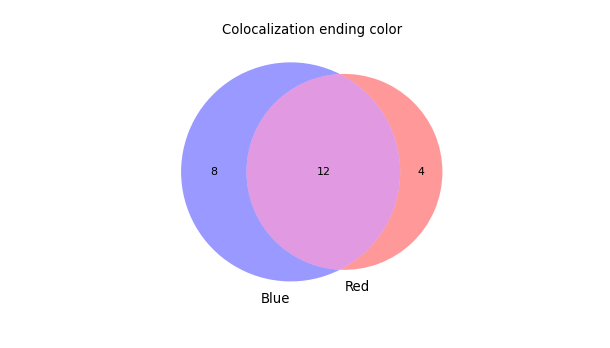

In [303]:
plt.figure(figsize=(7, 4))
venn2(subsets = (blueend, redend, doubleend), set_labels = ('Blue', 'Red'), set_colors=('blue', 'red'));
plt.title("Colocalization ending color")
plt.show()
#what color ends a colocalization event, i.e. the last color on

In [304]:
#colocalization lifetimes 
#determines how long interactions occur before one or both partners leaves
# as is this does not account for movement and assumes 1 colocalization for each set of lines

red_blue_colocalization_lifetimes = []
for i in range (0, len(interaction_tuple)):
    if interaction_starts[i] == 0: # this means that red came on first, so the start of the colocalization is the first blue time
        coloc_start = blue_lines.lines[interaction_tuple[i][1]].time_idx[0]
    if interaction_starts[i] == 1: # this means that both colors came on together. For now we'll just take the average start.
        coloc_start = ((blue_lines.lines[interaction_tuple[i][1]].time_idx[0] + red_lines.lines[interaction_tuple[i][0]].time_idx[0])/2)
    if interaction_starts[i] == 2: # this means that blue came on first, so the start of the colocalization is the first red time
        coloc_start = red_lines.lines[interaction_tuple[i][0]].time_idx[0]
    if interaction_ends[i] == 0: # this means that blue left last, so the end of the colocalization is the last red timepoint
        coloc_end = red_lines.lines[interaction_tuple[i][0]].time_idx[-1]
    if interaction_ends[i] == 1: # this means that both colors left together. For now we'll just take the average end.
        coloc_end = ((blue_lines.lines[interaction_tuple[i][1]].time_idx[-1] + red_lines.lines[interaction_tuple[i][0]].time_idx[-1])/2)    
    if interaction_ends[i] == 2: # this means that red left last, so the end of the colocalization is the last blue timepoint
        coloc_end = blue_lines.lines[interaction_tuple[i][1]].time_idx[-1]
        
    red_blue_colocalization_lifetimes.append((coloc_end-coloc_start) * dt*downsample_factor)
    
print (red_blue_colocalization_lifetimes)



[95.09391360000001, 1.5998976, 100.1935872, 3.5997696, 9.499392, 7.3995264, 0.8999424, 28.3981824, 12.0992256, 4.3997184, 4.0997376, 10.699315200000001, 27.998208, 3.2997888, 7.0995456, 3.1997952, 7.1995392, 1.7998848, -0.5999616, 5.4996480000000005, 0.5999616, 1.1999232, 1.3999104, 10.3993344]


In [305]:
#Analysis of single-color events without colocalization only, will output at end with the lengths of all events that didn't colocalize
        

def Filter(list1, list2):  #define a function to filter out any lines with interactions
    return (list(set(list2) - set(list1)))

blue_extracted_list = []
for i in range (0, len(interaction_tuple)):
    blue_extracted_list.append(interaction_tuple[i][0])
    
blue_line_list = np.arange(0, numberofbluelines, 1) #this generates a list of blue lines that did not colocalize
solo_blue_lines = Filter(blue_extracted_list, blue_line_list)



solo_blue_times_from_red = []
for k in range (0, len(solo_blue_lines)):
    solo_blue_times_from_red.append(bluetimes[solo_blue_lines[k]-1])


red_extracted_list = []
for i in range (0, len(interaction_tuple)):
    red_extracted_list.append(interaction_tuple[i][1])
    
red_line_list = np.arange(0, numberofredlines, 1) #this generates a list of red lines that did not colocalize
solo_red_lines = Filter(red_extracted_list, red_line_list)
#filtered = (list(set(red_line_list) - set(red_extracted_list)))



solo_red_times_from_blue = []
for k in range (0, len(solo_red_lines)):
    solo_red_times_from_blue.append(redtimes[solo_red_lines[k]-1])


<IPython.core.display.Javascript object>


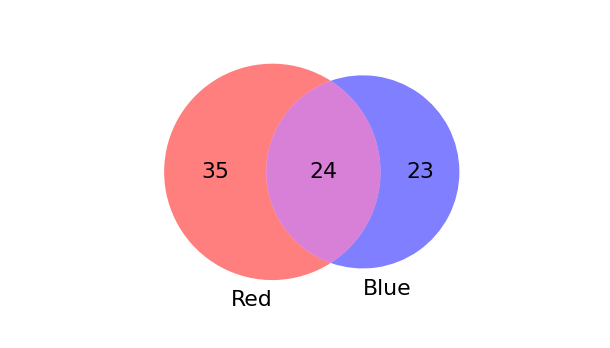

12 unique blue interactions
22 unique red interactions
35


In [306]:
#classic venn diagram showing how many red alone, how many blue alone, and how many colocalizations
#also lists unique interactions (i.e., how many lines of a color contribute to the middle portion)

plt.figure(figsize=(7, 4))
out=venn2(subsets = (len(solo_red_lines), len(solo_blue_lines), len(red_blue_colocalization_lifetimes)), set_labels = ('Red', 'Blue'), set_colors=('red', 'blue'), alpha = 0.5) 
for text in out.set_labels:
    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(20)    
plt.show()
print(len(bluetimes)-len(solo_blue_times_from_red),"unique blue interactions")
print(len(redtimes)-len(solo_red_times_from_blue),"unique red interactions")
print(len(bluetimes))

In [307]:
#outputs key parameters. Super useful for comparing multiple datasets.
#print (filename[0])

print (median_force)
print (bluelifetime)
print (numberofbluelines)
print (np.floor(max(time)), "s is the final timepoint")
print (dt)
print (pixel_size[0])
#print ('Localization precision is',np.average(standarddeviation)*1000, 'plus or minus', (sem(standarddeviation)*1000), 'nm, assuming no diffusion')

#this section saves down key parameters as .txt files. Can be used with the three-color analysis
np.savetxt("bluenorm_meanpositions.txt", 
           bluenorm_meanpositions,
           delimiter =", ",
            fmt = "%s")
np.savetxt("rednorm_meanpositions.txt", 
           rednorm_meanpositions,
           delimiter =", ",
            fmt = "%s")
np.savetxt("bluetimes.txt", 
           (np.sort (bluetimes)),
           delimiter =", ",
            fmt = "%s")
np.savetxt("redtimes.txt", 
           (np.sort (redtimes)),
           delimiter =", ",
            fmt = "%s")

np.savetxt("red_blue_colocalization_lifetimes.txt", 
           np.sort(red_blue_colocalization_lifetimes),
           delimiter =", ",
            fmt = "%s")
np.savetxt("solo_blue_times_from_red.txt", 
           (np.sort (solo_blue_times_from_red)),
           delimiter =", ",
            fmt = "%s")
np.savetxt("solo_red_times_from_blue.txt", 
           (np.sort (solo_red_times_from_blue)),
           delimiter =", ",
            fmt = "%s")

np.savetxt("blue_red_interaction_tuple.txt", 
           interaction_tuple,
           delimiter =", ",
            fmt = "%s")

xarray = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
yarray = np.array([len(solo_red_lines), len(solo_blue_lines), interaction_categories.count(3), interaction_categories.count(4), interaction_categories.count(5), interaction_categories.count(6), interaction_categories.count(7), interaction_categories.count(8), interaction_categories.count(9), interaction_categories.count(10), interaction_categories.count(11)])

data = np.column_stack([xarray, yarray])

np.savetxt("categories_of_colocalization.txt", data, fmt=['%d','%d'])

#this section saves all of the .txt files to a new folder based on colors of analysis
#this way, multiple analyses of the data will not erase each other.
parent_dir = os.getcwd()
directory = "redandblue"
newpath = os.path.join(parent_dir, directory)
os.mkdir(newpath)
path = os.getcwd() 

inpath = path
outpath = (newpath)
file_names = os.listdir(parent_dir)
os.chdir(inpath)
for file in glob.glob("*.txt"):
    shutil.copy(inpath+'/'+file,outpath)

8.473009341760012
9.391442290267111
35
1012.0 s is the final timepoint
0.0999936
0.1


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\schaichm\\OneDrive - University of Pittsburgh\\C-trap data\\20210907 gfpddb1 haloddb2\\20210907-192448 Kymograph 20 10 fps DNA7 10 pN\\redandblue'

<IPython.core.display.Javascript object>


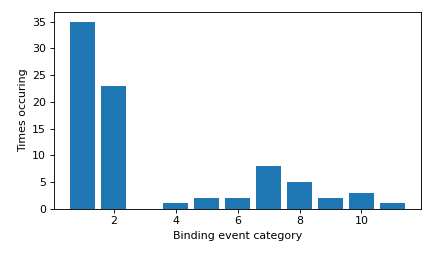

In [308]:
#rigorous way of showing order of assembly/dissassembly functions
#1 is blue alone
#2 is red alone
#3 is blue binds, red binds, blue dissociates, red dissociates
#4 is blue binds, red binds, blue and red dissociate together
#5 is blue binds, red binds, red dissociates, blue dissociates
#6 is blue and red bind together, blue dissociates, red dissociates
#7 is blue and red bind together, blue and red leave together
#8 is blue and red bind together, red dissociates, blue dissociates
#9 is red binds, blue binds, blue dissociates, red dissociates
#10 is red binds, blue binds, blue and red dissociate together
#11 is red binds, blue binds, red dissociates, blue dissociates
plt.figure(figsize=(5, 3))
plt.bar(xarray, yarray)
plt.xlabel('Binding event category')
plt.ylabel('Times occuring')
#plt.yscale("log")
plt.tight_layout()
plt.show()